# Import libraries

In [4]:
# Data manipulation 
import pandas as pd

# Dates handling
from datetime import datetime, timedelta
import pytz
from dateutil.relativedelta import relativedelta

# Chart modules
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.plotting import figure
from bokeh.io import push_notebook,show, output_notebook
from bokeh.models import HoverTool
output_notebook()

# Linear algrebra
import numpy as np
import pywt
import math

# ML
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Technical indicators
from ta.momentum import rsi, stochrsi_d,stochrsi_k, stochrsi
from ta.trend import ema_indicator, macd_diff, vortex_indicator_neg, vortex_indicator_pos, adx, cci, sma_indicator
from ta.volatility import bollinger_hband, bollinger_lband
from ta.volume import ease_of_movement

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

# Filtering
from scipy.signal import savgol_filter

# Kucoin
from kucoin.client import Market
client = Market(url='https://api.kucoin.com')

Loading BokehJS ...

# Utils

In [5]:

def computeSuperTrend(df:pd.DataFrame,upper=False, lower=False)->pd.DataFrame:
    """Compute the super trend indicator for a dataframe.

    Args:
        df (pd.DataFrame): The input dataframe.

    Returns:
        pd.DataFrame: The resulting dataframe with 3 new columns
    """
    class SuperTrend():
        def __init__(
            self,
            High,
            Low,
            Close,
            atr_window=10,
            atr_multi=3
        ):
            self.High = High
            self.Low = Low
            self.Close = Close
            self.atr_window = atr_window
            self.atr_multi = atr_multi
            self._run()
            
        def _run(self):
            # calculate ATR
            price_diffs = [self.High - self.Low, 
                        self.High - self.Close.shift(), 
                        self.Close.shift() - self.Low]
            true_range = pd.concat(price_diffs, axis=1)
            true_range = true_range.abs().max(axis=1)
            # default ATR calculation in supertrend indicator
            atr = true_range.ewm(alpha=1/self.atr_window,min_periods=self.atr_window).mean() 
            # atr = ta.volatility.average_true_range(High, Low, Close, atr_period)
            # df['atr'] = df['tr'].rolling(atr_period).mean()
            
            # HL2 is simply the average of High and Low prices
            hl2 = (self.High + self.Low) / 2
            # upperband and lowerband calculation
            # notice that final bands are set to be equal to the respective bands
            final_upperband = upperband = hl2 + (self.atr_multi * atr)
            final_lowerband = lowerband = hl2 - (self.atr_multi * atr)
            
            # initialize Supertrend column to True
            supertrend = [True] * len(self.Close)
            
            for i in range(1, len(self.Close)):
                curr, prev = i, i-1
                
                # if current Close price crosses above upperband
                if self.Close[curr] > final_upperband[prev]:
                    supertrend[curr] = True
                # if current Close price crosses below lowerband
                elif self.Close[curr] < final_lowerband[prev]:
                    supertrend[curr] = False
                # else, the trend continues
                else:
                    supertrend[curr] = supertrend[prev]
                    
                    # adjustment to the final bands
                    if supertrend[curr] == True and final_lowerband[curr] < final_lowerband[prev]:
                        final_lowerband[curr] = final_lowerband[prev]
                    if supertrend[curr] == False and final_upperband[curr] > final_upperband[prev]:
                        final_upperband[curr] = final_upperband[prev]

                # to remove bands according to the trend direction
                if supertrend[curr] == True:
                    final_upperband[curr] = np.nan
                else:
                    final_lowerband[curr] = np.nan
                    
            self.st = pd.DataFrame({
                'Supertrend': supertrend,
                'Final Lowerband': final_lowerband,
                'Final Upperband': final_upperband
            })
            
        def superTrendUpper(self):
            return self.st['Final Upperband']
            
        def superTrendLower(self):
            return self.st['Final Lowerband']
            
        def superTrendDirection(self):
            return self.st['Supertrend']
        
    st = SuperTrend(df.High, df.Low, df.Close)
    
    if upper==True:
        df['ST_Upper']  = st.superTrendUpper()
    if lower==True:
        df['ST_Lower'] = st.superTrendLower()
    df['ST_Direction'] = st.superTrendDirection()
    return df

def addIndicators(df:pd.DataFrame,b_engulfings:bool=False, derivative:bool=False, double_derivative:bool=False) -> pd.DataFrame:
    """Apply indicators to the DataFrame.

    Args:
        df (pd.DataFrame): The dataframe you want to add indicators on.
        b_engulfings (bool, optional): Add bearish and bullish engulfing indicators. Defaults to False.
        derivative (bool, optional): Add the first derivative of the Close price. Defaults to False.
        double_derivative (bool, optional): Add the second derivative of the Close price. Defaults to False.

    Returns:
        pd.DataFrame: The same dataframe with indicators
    """
    def isBearishCandleStick(candle) -> bool:
        """Check whether a candle is a bearish candle or not

        Args:
            candle (pd.Series): The current candle that contains OHLC

        Returns:
            bool: A boolean representing if the candle is bearish candle (True) or not (False)
        """
        return candle['Close']<candle['Open']

    def isBullishCandleStick(candle) -> bool:
        """Check whether a candle is a bullish candle or not

        Args:
            candle (pd.Series): The current candle that contains OHLC

        Returns:
            bool: A boolean representing if the candle is bullish candle (True) or not (False)
        """
        return candle['Close']>candle['Open']

    def isBullishEngulfing(previous_candle,current_candle) -> int:
        """A function that check for bullish engulfing pattern through candle stick

        Args:
            previous_candle (pd.Series): The previous candle that contains OHLC
            current_candle (pd.Series): The current candle that contains OHLC

        Returns:
            int: represent the pattern spotting : 1 bullish engulfing, 0 not.
        """
        return 1 if isBearishCandleStick(previous_candle) and isBullishCandleStick(current_candle) and previous_candle['Open']<current_candle['Close'] and previous_candle['Close']>current_candle['Open'] else 0
        
    def isBearishEngulfing(previous_candle,current_candle) -> int:
        """A function that check for bearish engulfing pattern through candle stick

        Args:
            previous_candle (pd.Series): The previous candle that contains OHLC
            current_candle (pd.Series): The current candle that contains OHLC

        Returns:
            int: represent the pattern spotting : 1 bearish engulfing, 0 not.
        """
        return 1 if isBullishCandleStick(previous_candle) and isBearishCandleStick(current_candle) and previous_candle['Close']<current_candle['Open'] and previous_candle['Open']>current_candle['Close'] else 0    
            
    #df['RSI'] = rsi(df.Close,14,fillna=True)
    df['EMA20'] = ema_indicator(df.Close,20)
    df['EMA50'] = ema_indicator(df.Close,50)
    df['EMA100'] = ema_indicator(df.Close,100)
    df['EMA200'] = ema_indicator(df.Close,200)
    df['MACD'] = macd_diff(df.Close)
    df['Stoch_RSI'] = stochrsi(df.Close, 14, smooth1=3, smooth2=3)
    df['Vortex'] = (vortex_indicator_pos(df.High,df.Low,df.Close,20,fillna=True)-1)-(vortex_indicator_neg(df.High,df.Low,df.Close,20,fillna=True)-1)
    df['Bollinger_low'] = bollinger_hband(df.Close,20,fillna=True)
    df['Bollinger_high'] = bollinger_lband(df.Close,20,fillna=True)
    df['ADX'] = adx(df.High,df.Low,df.Close)
    df['CCI'] = cci(df.High,df.Low,df.Close,14)
    trixLength = 9
    trixSignal = 21
    df['TRIX'] = ema_indicator(ema_indicator(ema_indicator(df['Close'], window=trixLength), window=trixLength), window=trixLength)
    df['TRIX_PCT'] = df["TRIX"].pct_change()*100
    df['TRIX_SIGNAL'] = sma_indicator(df['TRIX_PCT'],trixSignal)
    df['TRIX_HISTO'] = df['TRIX_PCT'] - df['TRIX_SIGNAL']
    #df['EVM'] = ease_of_movement(df.High,df.Low,df.Volume,14)
    if b_engulfings==True:
        df['Bullish_engulfing'] = np.nan
        df['Bullish_engulfing'].iloc[1:] = [isBullishEngulfing(df.iloc[i-1],df.iloc[i]) for i in range(1,len(df))]
        df['Bearish_engulfing'] = np.nan
        df['Bearish_engulfing'].iloc[1:] = [isBearishEngulfing(df.iloc[i-1],df.iloc[i]) for i in range(1,len(df))]
    if derivative==True:
        df['Slope'] = df.Close.diff()
    if double_derivative==True:
        df['Acceleration'] = df.Close.diff().diff()
    return computeSuperTrend(df).dropna()

In [6]:
df = pd.read_csv('../backtest_tools/database/database/Binance/1h/AAVE-USDT.csv',names=['Date','Open','High','Low','Close','Volume'])
df = df.iloc[1:]
df['Date'] = df['Date'].apply(lambda x: int(str(x)[:-3]))
df = df.astype(float)
df['Timestamp'] = df['Date'].astype(int)
df['Date'] = df['Date'].astype(int).apply(datetime.fromtimestamp)
df = df.set_index('Date')
df = addIndicators(df)
df.head()

,Open,High,Low,Close,Volume,Timestamp,EMA20,EMA50,EMA100,EMA200,...,Vortex,Bollinger_low,Bollinger_high,ADX,CCI,TRIX,TRIX_PCT,TRIX_SIGNAL,TRIX_HISTO,ST_Direction
Date,,,,,,,,,,,,,,,,,,,,,
2020-10-23 12:00:00,39.928,41.000,39.656,41.000,6252.871,1603447200,38.811707,37.356607,37.281497,38.954571,...,0.272337,41.174598,36.657202,43.742422,97.678574,38.290005,0.459222,0.462010,-0.002787,True
2020-10-23 13:00:00,40.911,41.293,40.329,40.608,6817.523,1603450800,38.982782,37.484113,37.347369,38.971023,...,0.284193,41.286636,36.907964,44.713553,93.663973,38.468130,0.465199,0.476942,-0.011744,True
2020-10-23 14:00:00,40.636,40.771,40.190,40.569,4293.634,1603454400,39.133851,37.605089,37.411163,38.986923,...,0.249894,41.409500,37.083800,45.361469,69.318206,38.646119,0.462694,0.487486,-0.024791,True
2020-10-23 15:00:00,40.597,41.470,40.459,40.701,9283.957,1603458000,39.283103,37.726497,37.476309,39.003978,...,0.214817,41.551925,37.051375,46.322902,83.490328,38.821968,0.455024,0.493763,-0.038739,True
2020-10-23 16:00:00,40.644,41.192,40.374,40.424,7446.313,1603461600,39.391760,37.832282,37.534679,39.018108,...,0.160786,41.671459,37.085541,47.056019,65.854036,38.991249,0.436044,0.493778,-0.057734,True


# High higher than preivous close

Distribution (True = High of day i higher than Close of day i-1): 
True     13675
False      392
Name: Higher_high, dtype: int64
Total True percentage : 97.21%

For the whole dataset :

- Average percentage the next high when it's higher than previous close : 1.15%
- Standard deviation percentage the next high when it's higher than previous close : 1.28%
- Median percentage the next high when it's higher than previous close : 0.8%
- Quantile 25 percentage the next high when it's higher than previous close : 0.36%

For the ideal dataset :

- Average percentage the next high when it's higher than previous close : 1.18%
- Standard deviation percentage the next high when it's higher than previous close : 1.29%
- Median percentage the next high when it's higher than previous close : 0.82%
- Quantile 25 percentage the next high when it's higher than previous close : 0.39%


<AxesSubplot:title={'center':'Corresponding boxplot'}, xlabel='High_pct_change'>

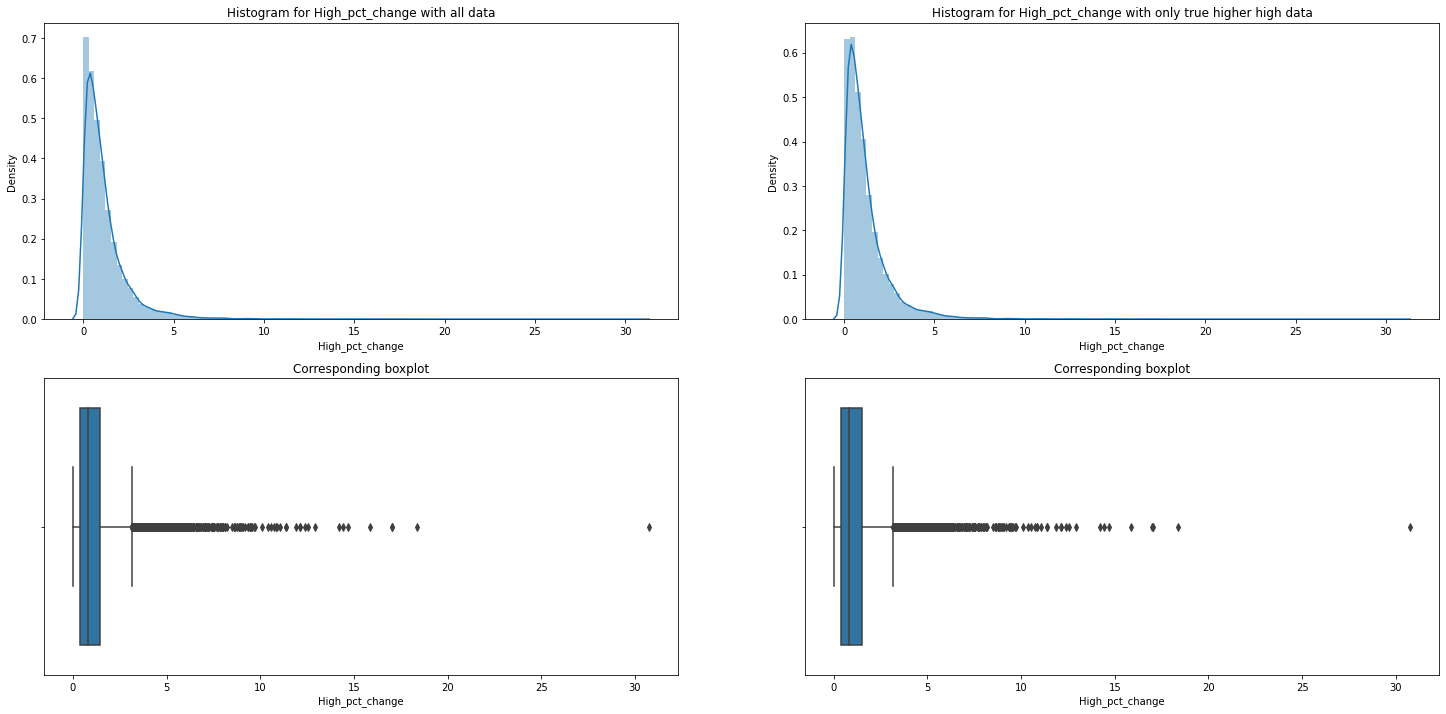

In [11]:
df['Higher_high'] = np.nan
df['Higher_high'].iloc[1:] = [df['High'].iloc[i]>df['Close'].iloc[i-1] for i in range(1,len(df))]
df['High_pct_change'] = np.nan
df['High_pct_change'].iloc[1:] = [100*abs(df['Close'].iloc[i-1]-df['High'].iloc[i])/df['Close'].iloc[i-1] for i in range(1,len(df))]
df['Change'] = df.Close.pct_change()*100
df.dropna(inplace=True)
print(f"Distribution (True = High of day i higher than Close of day i-1): \n{df['Higher_high'].value_counts()}")
print(f"Total True percentage : {round(100*len(df[df['Higher_high']==True])/len(df),2)}%")

print('\nFor the whole dataset :')
print(f"\n- Average percentage the next high when it's higher than previous close : {round(df['High_pct_change'].mean(),2)}%")
print(f"- Standard deviation percentage the next high when it's higher than previous close : {round(df['High_pct_change'].std(),2)}%")
print(f"- Median percentage the next high when it's higher than previous close : {round(df['High_pct_change'].median(),2)}%")
print(f"- Quantile 25 percentage the next high when it's higher than previous close : {round(df['High_pct_change'].quantile(q=0.25),2)}%")
print('\nFor the ideal dataset :')
print(f"\n- Average percentage the next high when it's higher than previous close : {round(df[df['Higher_high']==True]['High_pct_change'].mean(),2)}%")
print(f"- Standard deviation percentage the next high when it's higher than previous close : {round(df[df['Higher_high']==True]['High_pct_change'].std(),2)}%")
print(f"- Median percentage the next high when it's higher than previous close : {round(df[df['Higher_high']==True]['High_pct_change'].median(),2)}%")
print(f"- Quantile 25 percentage the next high when it's higher than previous close : {round(df[df['Higher_high']==True]['High_pct_change'].quantile(q=0.25),2)}%")


fig, ax1 = plt.subplots(2,2,figsize=(25,12))
ax1[0,0].set_title(f'Histogram for High_pct_change with all data')
sns.distplot(df.High_pct_change, hist=True,ax=ax1[0,0],bins=100)
ax1[1,0].set_title(f'Corresponding boxplot')
sns.boxplot(df.High_pct_change,ax=ax1[1,0])

ax1[0,1].set_title(f'Histogram for High_pct_change with only true higher high data')
sns.distplot(df[df['Higher_high']==True].High_pct_change, hist=True,ax=ax1[0,1],bins=100)
ax1[1,1].set_title(f'Corresponding boxplot')
sns.boxplot(df[df['Higher_high']==True].High_pct_change,ax=ax1[1,1])

In [13]:
tp = df['High_pct_change'].quantile(q=0.25)/100
leverage = 1
equity = 50
gain = 0

df['WIN_LONG'] = np.nan
for i in range(1,len(df)): 
    #if df['ST_Direction'].iloc[i]==True:
        if df['High'].iloc[i]>=df['Close'].iloc[i-1]*(1+tp):
            df['WIN_LONG'].iloc[i] = True
            gain = gain + equity*(tp*leverage)
        else:
            df['WIN_LONG'].iloc[i] = False
            gain = gain - equity*(tp*leverage)
        
            
print(f'Starting equity : {equity} USDT')
print(f'Total pure gain {round(gain,2)} USDT')
print(f'Final balance {round(gain,2)+equity} USDT x{round((gain+equity)/equity,2)} ')
print(f'Winrate {round(100*df.WIN_LONG.value_counts()[1]/(df.WIN_LONG.value_counts()[1]+df.WIN_LONG.value_counts()[0]),2)} %')

df.WIN_LONG.value_counts()

Starting equity : 50 USDT
Total pure gain 1251.25 USDT
Final balance 1301.25 USDT x26.02 
Winrate 75.0 %


True     10549
False     3517
Name: WIN_LONG, dtype: int64

# Low Lower than preivous close

Distribution (True = High of day i higher than Close of day i-1): 
True     13666
False      402
Name: Lower_low, dtype: int64
Total True percentage : 97.14%

For the whole dataset :

- Average percentage the next high when it's higher than previous close : 1.15%
- Standard deviation percentage the next high when it's higher than previous close : 1.28%
- Median percentage the next high when it's higher than previous close : 0.8%
- Quantile 25 percentage the next high when it's higher than previous close : 0.36%

For the ideal dataset :

- Average percentage the next high when it's higher than previous close : 1.12%
- Standard deviation percentage the next high when it's higher than previous close : 1.26%
- Median percentage the next high when it's higher than previous close : 0.77%
- Quantile 25 percentage the next high when it's higher than previous close : 0.35%


<AxesSubplot:title={'center':'Corresponding boxplot'}, xlabel='Low_pct_change'>

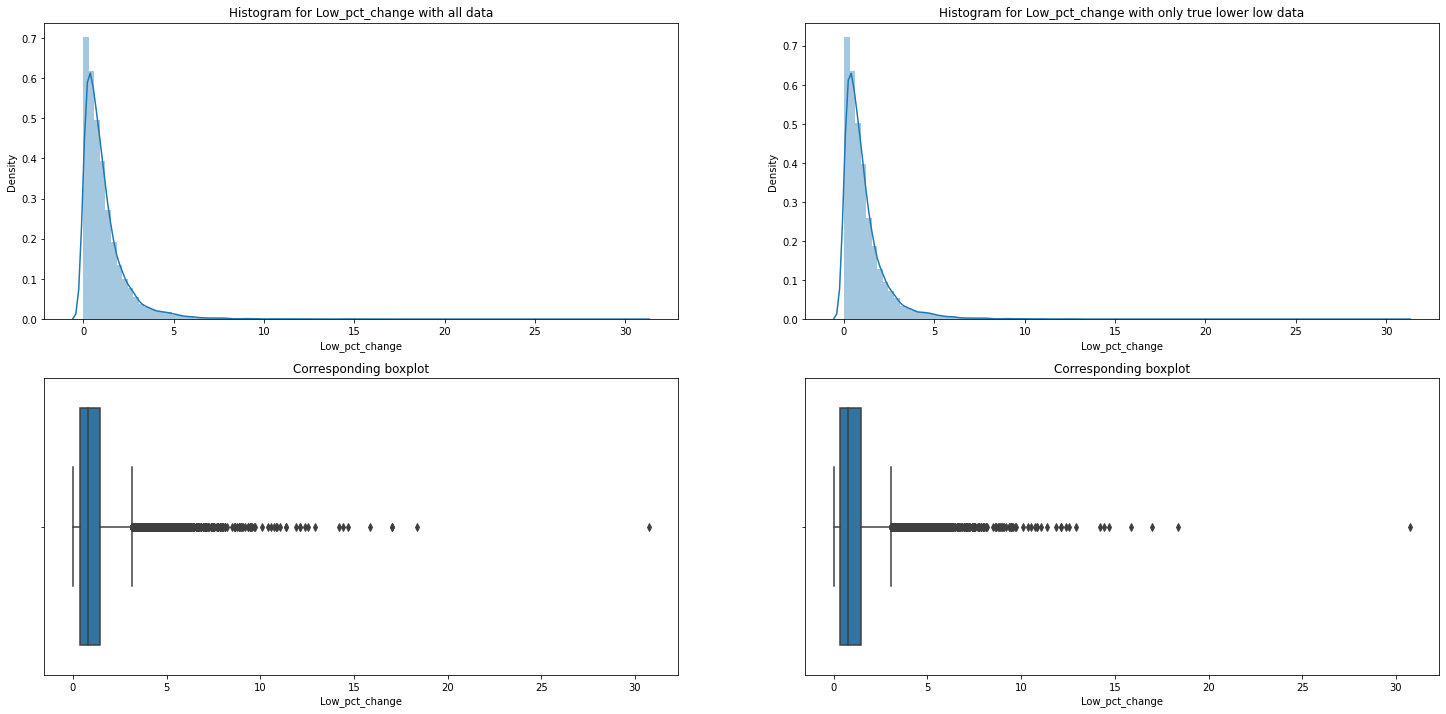

In [8]:
df['Lower_low'] = np.nan
df['Lower_low'].iloc[1:] = [df['Low'].iloc[i]<df['Close'].iloc[i-1] for i in range(1,len(df))]
df['Low_pct_change'] = np.nan
df['Low_pct_change'].iloc[1:] = [100*abs(df['Close'].iloc[i-1]-df['High'].iloc[i])/df['Close'].iloc[i-1] for i in range(1,len(df))]
df.dropna(inplace=True)
print(f"Distribution (True = High of day i higher than Close of day i-1): \n{df['Lower_low'].value_counts()}")
print(f"Total True percentage : {round(100*len(df[df['Lower_low']==True])/len(df),2)}%")

print('\nFor the whole dataset :')
print(f"\n- Average percentage the next high when it's higher than previous close : {round(df['Low_pct_change'].mean(),2)}%")
print(f"- Standard deviation percentage the next high when it's higher than previous close : {round(df['Low_pct_change'].std(),2)}%")
print(f"- Median percentage the next high when it's higher than previous close : {round(df['Low_pct_change'].median(),2)}%")
print(f"- Quantile 25 percentage the next high when it's higher than previous close : {round(df['Low_pct_change'].quantile(q=0.25),2)}%")
print('\nFor the ideal dataset :')
print(f"\n- Average percentage the next high when it's higher than previous close : {round(df[df['Lower_low']==True]['Low_pct_change'].mean(),2)}%")
print(f"- Standard deviation percentage the next high when it's higher than previous close : {round(df[df['Lower_low']==True]['Low_pct_change'].std(),2)}%")
print(f"- Median percentage the next high when it's higher than previous close : {round(df[df['Lower_low']==True]['Low_pct_change'].median(),2)}%")
print(f"- Quantile 25 percentage the next high when it's higher than previous close : {round(df[df['Lower_low']==True]['Low_pct_change'].quantile(q=0.25),2)}%")


fig, ax1 = plt.subplots(2,2,figsize=(25,12))
ax1[0,0].set_title(f'Histogram for Low_pct_change with all data')
sns.distplot(df.Low_pct_change, hist=True,ax=ax1[0,0],bins=100)
ax1[1,0].set_title(f'Corresponding boxplot')
sns.boxplot(df.Low_pct_change,ax=ax1[1,0])

ax1[0,1].set_title(f'Histogram for Low_pct_change with only true lower low data')
sns.distplot(df[df['Lower_low']==True].Low_pct_change, hist=True,ax=ax1[0,1],bins=100)
ax1[1,1].set_title(f'Corresponding boxplot')
sns.boxplot(df[df['Lower_low']==True].Low_pct_change,ax=ax1[1,1])

In [9]:
tp = df['Low_pct_change'].quantile(q=0.25)/100
leverage = 5
equity = 1500
gain = 0

df['WIN_SHORT'] = np.nan
for i in range(1,len(df)): 
        if df['Low'].iloc[i]<=df['Close'].iloc[i-1]*(1-tp):
            df['WIN_SHORT'].iloc[i] = True
            gain = gain + equity*(tp*leverage)
        else:
            df['WIN_SHORT'].iloc[i] = False
            gain = gain - equity*(tp*leverage)
            
print(f'Starting equity : {equity} USDT')
print(f'Total pure gain {round(gain,2)} USDT')
print(f'Final balance {round(gain,2)+equity} USDT x{round((gain+equity)/equity,2)} ')
print(f'Winrate {round(100*df.WIN_SHORT.value_counts()[1]/(df.WIN_SHORT.value_counts()[1]+df.WIN_SHORT.value_counts()[0]),2)} %')
df.WIN_SHORT.value_counts()


Starting equity : 1500 USDT
Total pure gain 200685.05 USDT
Final balance 202185.05 USDT x134.79 
Winrate 76.73 %


True     10793
False     3274
Name: WIN_SHORT, dtype: int64